In [31]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models

In [46]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


## Data

Data is obtained from https://github.com/AtharvaTaras/Dog-Breeds-Dataset

In [ ]:
BATCH_SIZE = 32
FILE_PATH = os.path.join('..', 'images')
IMG_SIZE = 128

# Remove transparency
def pil_loader_rgb(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_transform_augmented = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder(root=os.path.join(FILE_PATH), transform=transform, loader=pil_loader_rgb)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_dataset.dataset.transform = train_transform_augmented
test_dataset.dataset.transform = test_transform

# Filter to X classes
X = 10

keep_classes = full_dataset.classes[:X]

full_dataset.samples = [s for s in full_dataset.samples if s[1] < X]
full_dataset.targets = [label for _, label in full_dataset.samples]

full_dataset.classes = keep_classes
full_dataset.class_to_idx = {c: i for i, c in enumerate(keep_classes)}

num_classes = X

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

## Model

### Training Loop

In [48]:
criterion = nn.CrossEntropyLoss()

def compute_correct_labels(outputs, labels):
    _, predicted_values = torch.max(outputs, 1)
    correct = (predicted_values == labels).sum().item()
    total = labels.size(0)
    return correct, total

def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    train_losses = []
    test_losses = []
    
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return(train_losses, test_losses)

def train(model, optimizer, num_epochs):
    return training_loop(model, optimizer, num_epochs, train_loader, test_loader, printing=True)

### Basic CNN

In [49]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            sample = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            conv_out = self.conv_layers(sample)
            conv_output_size = conv_out.view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(conv_output_size, 32), 
            nn.ReLU(),

            nn.Dropout(p=0.3),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [50]:
NUM_EPOCHS1 = 20
model1 = ClassificationCNN().to(device)
train_losses1, test_losses1 = train(
    model=model1,
    optimizer=optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4),
    num_epochs=NUM_EPOCHS1,
)

Epoch 1/20 - Train Loss: 2.6306, Train Correct: 30/278 - Test Loss: 2.3054, Test Correct: 7/70 
Epoch 2/20 - Train Loss: 2.2880, Train Correct: 35/278 - Test Loss: 2.2931, Test Correct: 7/70 
Epoch 3/20 - Train Loss: 2.2800, Train Correct: 35/278 - Test Loss: 2.2749, Test Correct: 6/70 
Epoch 4/20 - Train Loss: 2.2360, Train Correct: 40/278 - Test Loss: 2.2785, Test Correct: 5/70 
Epoch 5/20 - Train Loss: 2.2398, Train Correct: 38/278 - Test Loss: 2.2507, Test Correct: 6/70 
Epoch 6/20 - Train Loss: 2.1764, Train Correct: 44/278 - Test Loss: 2.2144, Test Correct: 7/70 
Epoch 7/20 - Train Loss: 2.1709, Train Correct: 38/278 - Test Loss: 2.1847, Test Correct: 8/70 
Epoch 8/20 - Train Loss: 2.1319, Train Correct: 38/278 - Test Loss: 2.1955, Test Correct: 8/70 
Epoch 9/20 - Train Loss: 2.0844, Train Correct: 42/278 - Test Loss: 2.1739, Test Correct: 9/70 
Epoch 10/20 - Train Loss: 2.0697, Train Correct: 41/278 - Test Loss: 2.1911, Test Correct: 7/70 
Epoch 11/20 - Train Loss: 2.0842, Train

### Pre-trained Model

In [51]:
model2 = models.resnet18(weights='IMAGENET1K_V1')
model2.fc = nn.Linear(model2.fc.in_features, num_classes)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

model2= model2.to(device)

In [52]:
NUM_EPOCHS2 = 20
train_losses2, test_losses2 = train(
    model=model2,
    optimizer=optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4),
    num_epochs=NUM_EPOCHS2,
)

Epoch 1/20 - Train Loss: 2.3457, Train Correct: 40/278 - Test Loss: 1.9846, Test Correct: 18/70 
Epoch 2/20 - Train Loss: 1.6758, Train Correct: 132/278 - Test Loss: 1.4984, Test Correct: 44/70 
Epoch 3/20 - Train Loss: 1.2750, Train Correct: 181/278 - Test Loss: 1.3156, Test Correct: 45/70 
Epoch 4/20 - Train Loss: 0.9799, Train Correct: 216/278 - Test Loss: 1.1242, Test Correct: 52/70 
Epoch 5/20 - Train Loss: 0.8086, Train Correct: 224/278 - Test Loss: 1.0357, Test Correct: 54/70 
Epoch 6/20 - Train Loss: 0.7266, Train Correct: 236/278 - Test Loss: 0.9991, Test Correct: 51/70 
Epoch 7/20 - Train Loss: 0.6354, Train Correct: 240/278 - Test Loss: 0.9484, Test Correct: 56/70 
Epoch 8/20 - Train Loss: 0.5567, Train Correct: 246/278 - Test Loss: 0.8927, Test Correct: 58/70 
Epoch 9/20 - Train Loss: 0.5105, Train Correct: 254/278 - Test Loss: 0.8914, Test Correct: 54/70 
Epoch 10/20 - Train Loss: 0.4731, Train Correct: 262/278 - Test Loss: 0.8818, Test Correct: 56/70 
Epoch 11/20 - Train 

## Results

In [58]:
def plot_loss(num_epochs, train_losses,  test_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), train_losses, 'd-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, 'd-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def show_predictions(model):
    # define the species for each category
    species = full_dataset.classes
    sub = 5

    # Set model to evaluation mode
    model.eval()

    # make a figure object
    fig = plt.figure(figsize=(sub*3, 5*3))
    gs = gridspec.GridSpec(5, sub)

    # loop through each species (column)
    for i, s in enumerate(species[:sub]):

        # loop through the image files
        file_list = os.listdir(os.path.join(FILE_PATH, str(s)))[:5]
        for file_count, file_name in enumerate(file_list):

            # load the image
            image = Image.open(os.path.join(FILE_PATH,str(s), file_name)).convert('RGB')
            input_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension
            
            # get the predicted class
            with torch.no_grad():
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
            predicted_class = species[predicted.item()]

            # add the image to the plot with the prediction
            ax = fig.add_subplot(gs[file_count, i])
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(predicted_class)

    plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
    plt.show()

### Basic CNN

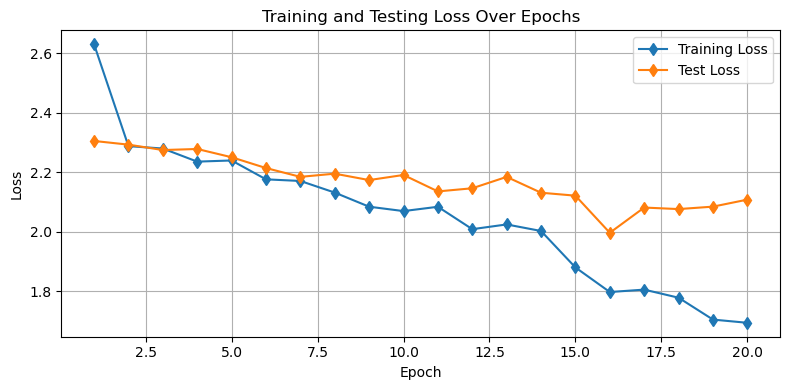

In [59]:
plot_loss(NUM_EPOCHS1, train_losses1, test_losses1)

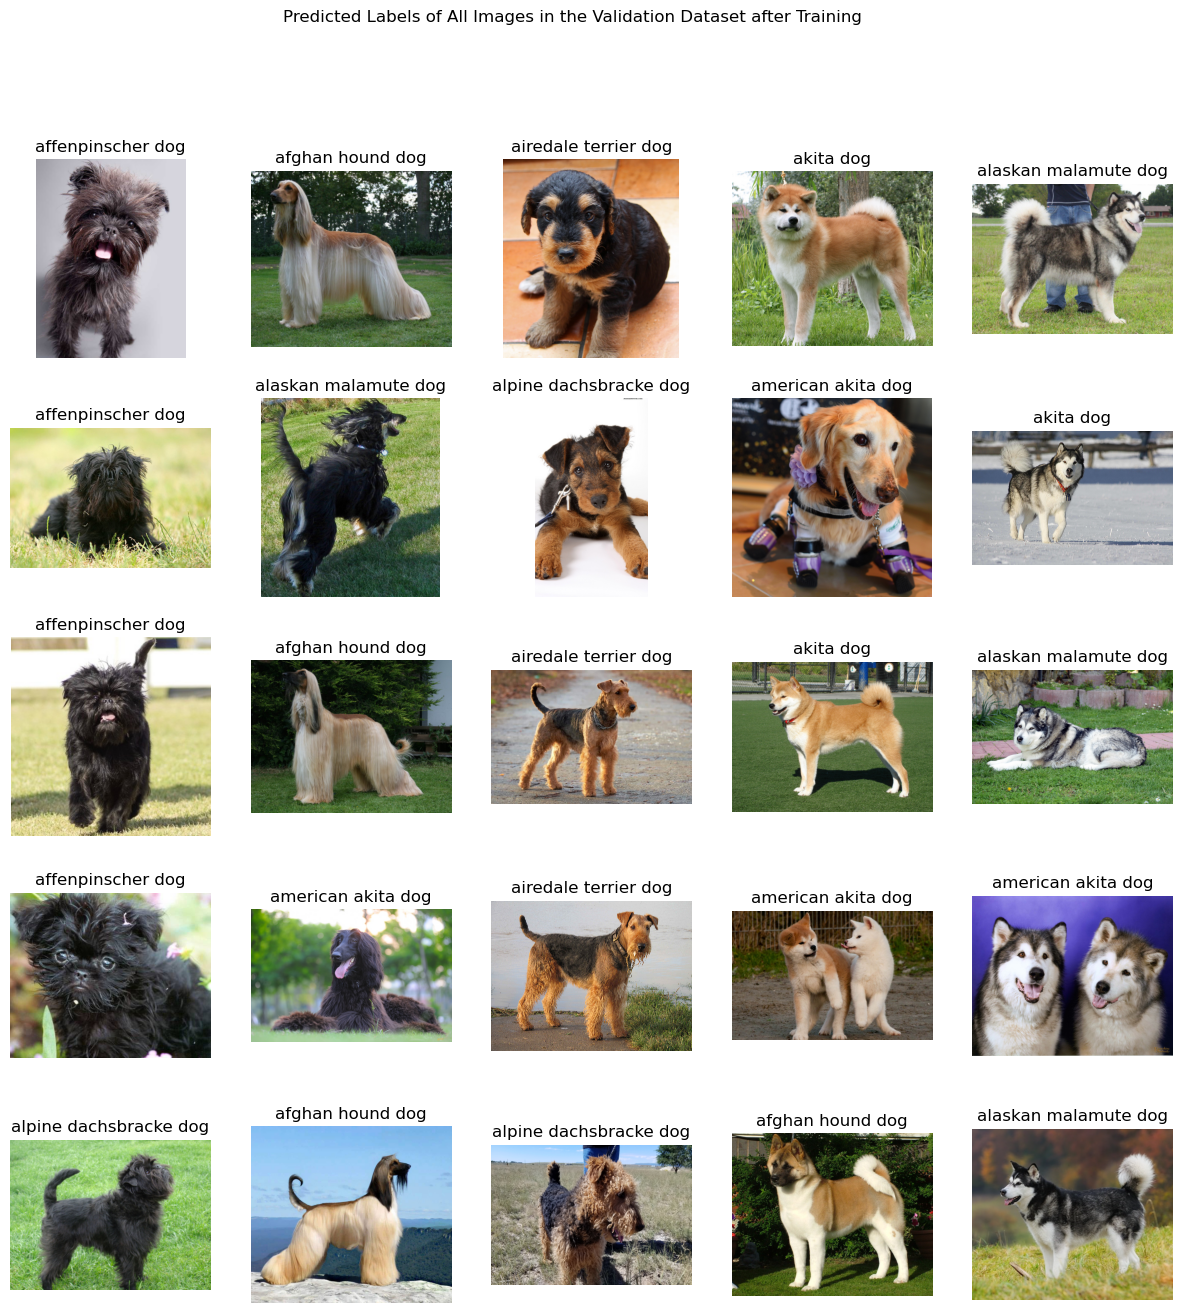

In [60]:
show_predictions(model1)

### Pre-trained Model

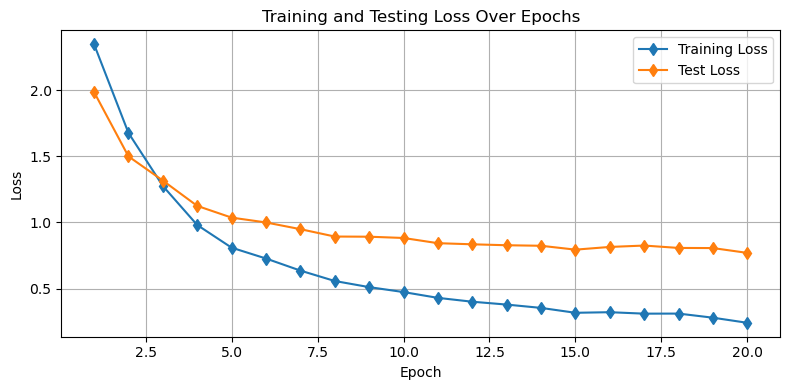

In [61]:
plot_loss(NUM_EPOCHS2, train_losses2, test_losses2)

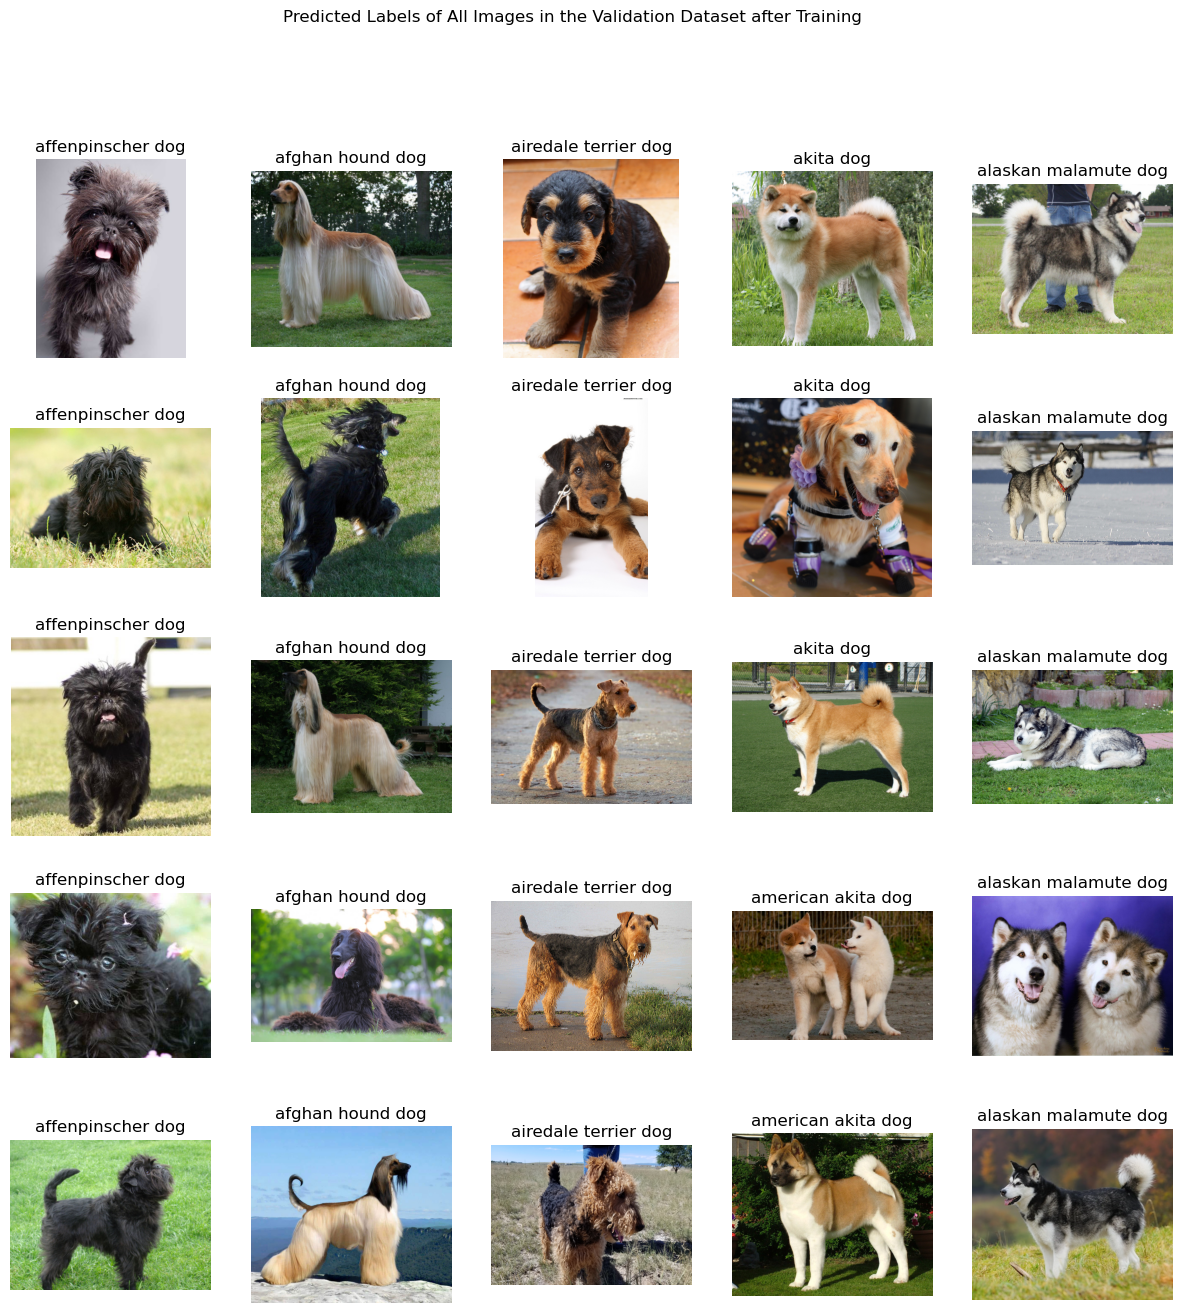

In [62]:
show_predictions(model2)